In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm

# Dataset class remains the same
class RiceDiseaseDataset(Dataset):
    def __init__(self, csv_file, base_path, transform=None, verbose=True):
        self.data = pd.read_csv(csv_file)
        self.base_path = base_path
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(self.data['label'].unique())}

        self.valid_data = []
        for _, row in self.data.iterrows():
            img_name = row['image_id']
            label = row['label']

            potential_path = os.path.join(self.base_path, label, img_name)
            if os.path.exists(potential_path):
                self.valid_data.append({
                    'image_path': potential_path,
                    'label': label
                })

        if verbose:
            print(f"Number of classes: {len(self.label_mapping)}")
            print("Label mapping:", self.label_mapping)
            print(f"Found {len(self.valid_data)} valid images")

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        item = self.valid_data[idx]
        img = Image.open(item['image_path']).convert('RGB')
        label = self.label_mapping[item['label']]

        if self.transform:
            img = self.transform(img)

        return img, label

# Modified CustomRiceNet with offline initialization
class CustomRiceNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomRiceNet, self).__init__()

        # Initialize models without pre-trained weights
        self.resnet_features = models.resnet18(pretrained=False)
        resnet_out = self.resnet_features.fc.in_features
        self.resnet_features.fc = nn.Identity()

        self.densenet_features = models.densenet121(pretrained=False)
        densenet_out = self.densenet_features.classifier.in_features
        self.densenet_features.classifier = nn.Identity()

        combined_features = resnet_out + densenet_out

        self.attention = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        self.fusion = nn.Sequential(
            nn.Linear(combined_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        resnet_out = self.resnet_features(x)
        densenet_out = self.densenet_features(x)
        combined_features = torch.cat((resnet_out, densenet_out), dim=1)
        attention_weights = self.attention(combined_features)
        weighted_features = combined_features * attention_weights
        fused_features = self.fusion(weighted_features)
        output = self.classifier(fused_features)
        return output

# Loss function remains the same
class CustomRiceLoss(nn.Module):
    def __init__(self):
        super(CustomRiceLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        return self.criterion(outputs, targets)

# Modified main function with offline handling
def main():
    # Set random seed
    torch.manual_seed(42)

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets with error handling
    try:
        csv_file = '/content/drive/MyDrive/RiceLeafDataset/image_labels.csv'
        base_path = '/content/drive/MyDrive/RiceLeafDataset'

        full_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=None, verbose=True)

        # Split indices
        train_indices, val_indices = train_test_split(
            range(len(full_dataset)),
            test_size=0.3,
            random_state=42
        )

        # Create datasets
        train_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=train_transforms, verbose=False)
        val_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=val_transforms, verbose=False)

        # Create subsets
        train_subset = Subset(train_dataset, train_indices)
        val_subset = Subset(val_dataset, val_indices)

        # Create dataloaders with reduced number of workers for Kaggle
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)

        print("Data loaders created successfully!")

    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None, None, None, None

    try:
        # Initialize model without pretrained weights
        model = CustomRiceNet(num_classes=len(full_dataset.label_mapping))
        model = model.to(device)

        # Initialize loss and optimizer
        criterion = CustomRiceLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=3, verbose=True
        )

        # Train the model
        training_history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            num_epochs=30
        )

        # Save training history
        pd.DataFrame(training_history).to_csv('training_history.csv', index=False)

        return full_dataset, model, train_loader, val_loader, device

    except Exception as e:
        print(f"Error in model training setup: {str(e)}")
        return None, None, None, None, None

if __name__ == '__main__':
    full_dataset, model, train_loader, val_loader, device = main()

Using device: cuda
Number of classes: 3
Label mapping: {'Leafsmut': 0, 'Bacterialblight': 1, 'Brownspot': 2}
Found 3898 valid images
Data loaders created successfully!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/30


Validation: 100%|██████████| 37/37 [14:15<00:00, 23.12s/it]


Train Loss: 0.8841 | Train Acc: 61.33%
Val Loss: 1.0115 | Val Acc: 65.13%

Epoch 2/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Train Loss: 0.7277 | Train Acc: 68.26%
Val Loss: 0.8187 | Val Acc: 66.75%

Epoch 3/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Train Loss: 0.6749 | Train Acc: 71.85%
Val Loss: 0.5358 | Val Acc: 80.17%

Epoch 4/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Train Loss: 0.6411 | Train Acc: 72.65%
Val Loss: 0.6727 | Val Acc: 68.55%

Epoch 5/30


Validation: 100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Train Loss: 0.5847 | Train Acc: 76.10%
Val Loss: 0.5847 | Val Acc: 71.97%

Epoch 6/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Train Loss: 0.5725 | Train Acc: 76.50%
Val Loss: 0.6158 | Val Acc: 71.97%

Epoch 7/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Train Loss: 0.5190 | Train Acc: 78.78%
Val Loss: 0.6209 | Val Acc: 73.59%

Epoch 8/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Train Loss: 0.4688 | Train Acc: 80.65%
Val Loss: 0.3964 | Val Acc: 81.54%

Epoch 9/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Train Loss: 0.4277 | Train Acc: 83.28%
Val Loss: 0.3967 | Val Acc: 82.31%

Epoch 10/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Train Loss: 0.3735 | Train Acc: 85.48%
Val Loss: 0.3117 | Val Acc: 85.81%

Epoch 11/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Train Loss: 0.3875 | Train Acc: 84.71%
Val Loss: 0.3087 | Val Acc: 87.52%

Epoch 12/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Train Loss: 0.3629 | Train Acc: 85.92%
Val Loss: 0.3390 | Val Acc: 86.32%

Epoch 13/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Train Loss: 0.3397 | Train Acc: 87.06%
Val Loss: 0.2607 | Val Acc: 89.40%

Epoch 14/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Train Loss: 0.3352 | Train Acc: 87.43%
Val Loss: 0.2815 | Val Acc: 88.72%

Epoch 15/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Train Loss: 0.3156 | Train Acc: 87.76%
Val Loss: 0.2799 | Val Acc: 88.72%

Epoch 16/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Train Loss: 0.3017 | Train Acc: 88.82%
Val Loss: 0.2493 | Val Acc: 90.09%

Epoch 17/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Train Loss: 0.2938 | Train Acc: 88.78%
Val Loss: 0.2514 | Val Acc: 89.06%

Epoch 18/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Train Loss: 0.2933 | Train Acc: 88.23%
Val Loss: 0.2162 | Val Acc: 91.97%

Epoch 19/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Train Loss: 0.2727 | Train Acc: 90.10%
Val Loss: 0.2180 | Val Acc: 90.00%

Epoch 20/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Train Loss: 0.2450 | Train Acc: 91.53%
Val Loss: 0.1708 | Val Acc: 94.36%

Epoch 21/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Train Loss: 0.2677 | Train Acc: 90.36%
Val Loss: 0.1475 | Val Acc: 94.53%

Epoch 22/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Train Loss: 0.2617 | Train Acc: 90.40%
Val Loss: 0.1905 | Val Acc: 92.22%

Epoch 23/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Train Loss: 0.2364 | Train Acc: 91.24%
Val Loss: 0.2008 | Val Acc: 91.37%

Epoch 24/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Train Loss: 0.2138 | Train Acc: 91.17%
Val Loss: 0.1272 | Val Acc: 95.73%

Epoch 25/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Train Loss: 0.2100 | Train Acc: 91.72%
Val Loss: 0.1232 | Val Acc: 95.90%

Epoch 26/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Train Loss: 0.1913 | Train Acc: 92.96%
Val Loss: 0.1296 | Val Acc: 95.73%

Epoch 27/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Train Loss: 0.1781 | Train Acc: 93.51%
Val Loss: 0.1140 | Val Acc: 96.15%

Epoch 28/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Train Loss: 0.2001 | Train Acc: 92.30%
Val Loss: 0.1173 | Val Acc: 95.21%

Epoch 29/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Train Loss: 0.1866 | Train Acc: 92.67%
Val Loss: 0.0780 | Val Acc: 97.01%

Epoch 30/30


Validation: 100%|██████████| 37/37 [00:11<00:00,  3.31it/s]

Train Loss: 0.1515 | Train Acc: 94.24%
Val Loss: 0.0945 | Val Acc: 95.47%


In [ ]:
import os
import pandas as pd

# Define the root directory of the dataset
dataset_dir = '/content/drive/MyDrive/RiceLeafDataset'

# List to store image_id and label
image_data = []

# Walk through the dataset directory
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)

    # Ensure it's a folder
    if os.path.isdir(folder_path):
        # Get all images in the folder
        for image_name in os.listdir(folder_path):
            if image_name.endswith('.jpg'):  # Adjust the extension if needed
                image_data.append([image_name, folder_name])

# Create a DataFrame
df = pd.DataFrame(image_data, columns=['image_id', 'label'])

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/RiceLeafDataset/image_labels.csv', index=False)

print("CSV file 'image_labels.csv' has been created.")


CSV file 'image_labels.csv' has been created.


In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm

In [3]:
# Read Dataset Custom:
class RiceDiseaseDataset(Dataset):
    def __init__(self, csv_file, base_path, transform=None, verbose=True):
        self.data = pd.read_csv(csv_file)
        self.base_path = base_path
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(self.data['label'].unique())}

        # Store valid image paths
        self.valid_data = []
        for _, row in self.data.iterrows():
            img_name = row['image_id']
            label = row['label']

            # Check in label subdirectory
            potential_path = os.path.join(self.base_path, label, img_name)
            if os.path.exists(potential_path):
                self.valid_data.append({
                    'image_path': potential_path,
                    'label': label
                })

        # Print dataset information if verbose is True
        if verbose:
            print(f"Number of classes: {len(self.label_mapping)}")
            print("Label mapping:", self.label_mapping)
            print(f"Found {len(self.valid_data)} valid images")

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        item = self.valid_data[idx]
        img = Image.open(item['image_path']).convert('RGB')
        label = self.label_mapping[item['label']]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
# Loss Calculation:

class CustomRiceLoss(nn.Module):
    def __init__(self):
        super(CustomRiceLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        return self.criterion(outputs, targets)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    best_val_loss = float('inf')
    training_history = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, targets in tqdm(train_loader, desc='Training'):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validation'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, 'best_custom_rice_model.pth')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Store results
        training_history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    return training_history

In [6]:
def dataset_statistics(train_loader, val_loader):
    total_train_images = sum(len(batch[0]) for batch in train_loader)
    total_val_images = sum(len(batch[0]) for batch in val_loader)
    total_images = total_train_images + total_val_images

    print(f"Total Images: {total_images}")
    print(f"Total Training Images: {total_train_images}")
    print(f"Total Validation Images: {total_val_images}")

In [ ]:
def main():
    # Set random seed
    torch.manual_seed(42)

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    csv_file = '/content/drive/MyDrive/RiceLeafDataset/image_labels.csv'
    base_path = '/content/drive/MyDrive/RiceLeafDataset'

    # Create full dataset and print information
    full_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=None, verbose=True)

    # Split indices
    train_indices, val_indices = train_test_split(
        range(len(full_dataset)),
        test_size=0.3,
        random_state=42
    )

    # Create train and validation datasets without printing
    train_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=train_transforms, verbose=False)
    val_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=val_transforms, verbose=False)

    # Create subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # Create dataloaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

    # Call dataset statistics to print the image stats
    dataset_statistics(train_loader, val_loader)

    # Initialize model
    model = CustomRiceNet(num_classes=len(full_dataset.label_mapping))
    model = model.to(device)

    # Initialize loss and optimizer
    criterion = CustomRiceLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Train the model
    training_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=50
    )

    # Save training history
    pd.DataFrame(training_history).to_csv('training_history.csv', index=False)

    return full_dataset, model, train_loader, val_loader, device

if __name__ == '__main__':
    full_dataset, model, train_loader, val_loader, device = main()


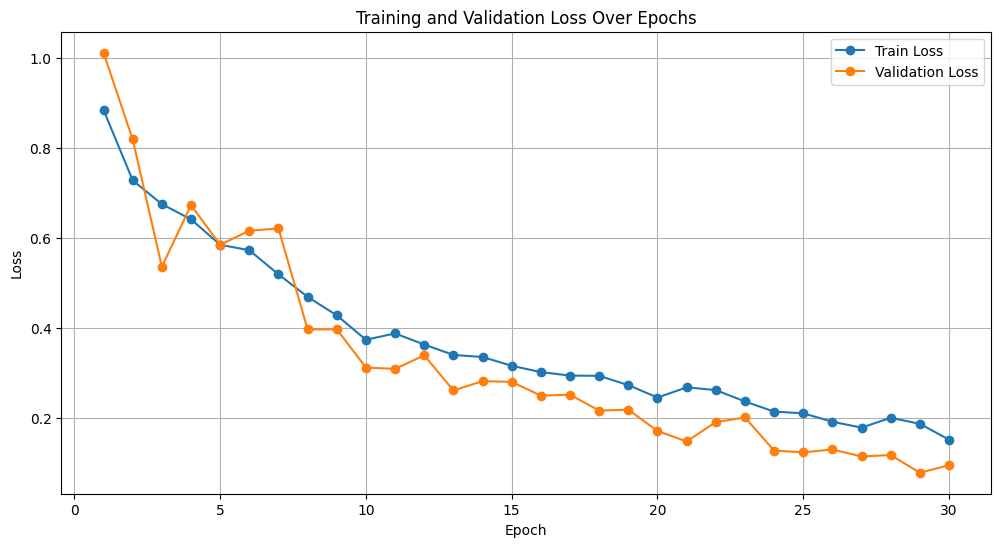

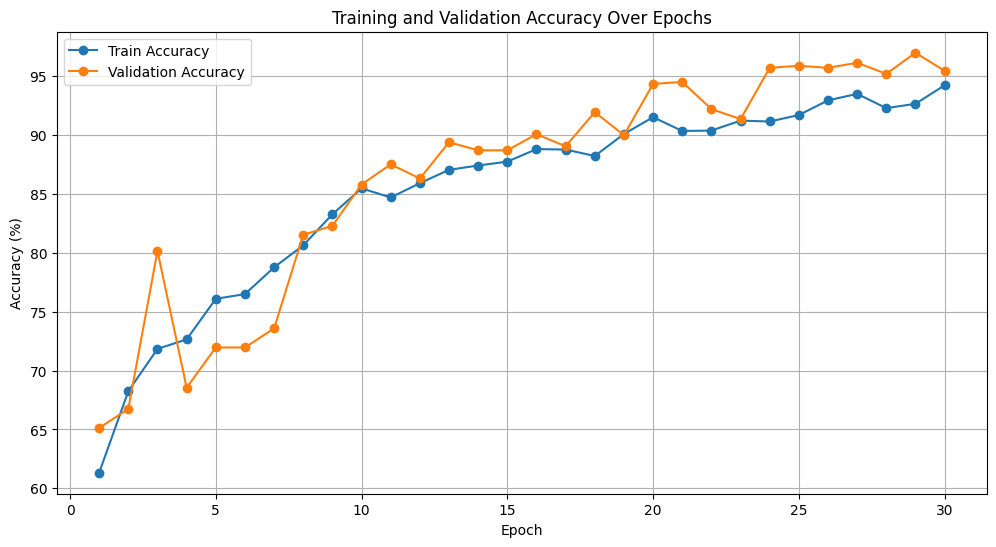

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
training_history = pd.read_csv('training_history.csv')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(training_history['epoch'], training_history['train_loss'], label='Train Loss', marker='o')
plt.plot(training_history['epoch'], training_history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_history['epoch'], training_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(training_history['epoch'], training_history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

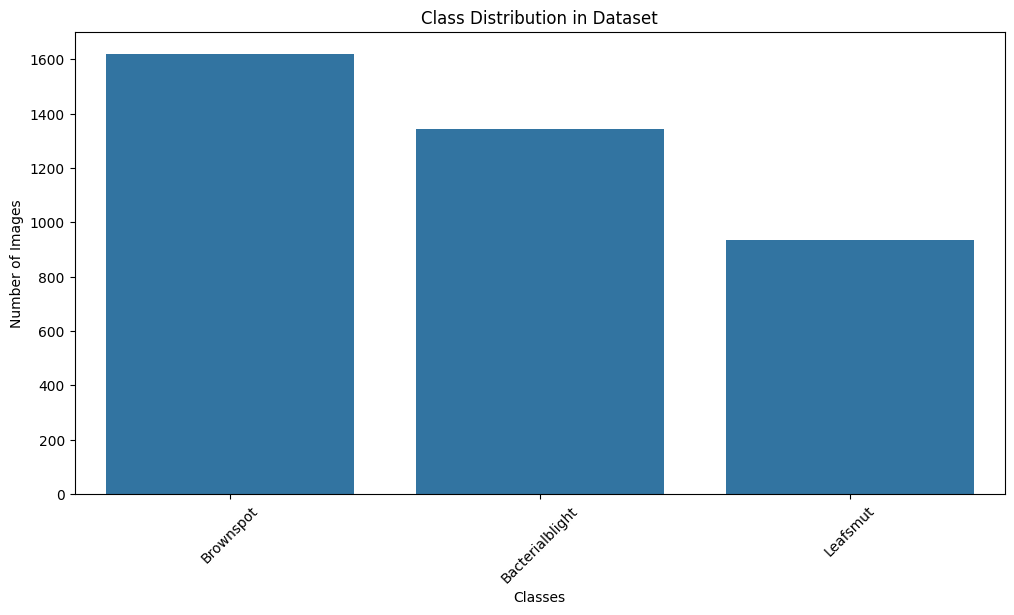

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset analysis
class_counts = full_dataset.data['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Confusion Matrix:
 [[303   0   0]
 [ 14 366   0]
 [ 13  26 448]]

Classification Report:
                  precision    recall  f1-score   support

       Leafsmut       0.92      1.00      0.96       303
Bacterialblight       0.93      0.96      0.95       380
      Brownspot       1.00      0.92      0.96       487

       accuracy                           0.95      1170
      macro avg       0.95      0.96      0.95      1170
   weighted avg       0.96      0.95      0.95      1170



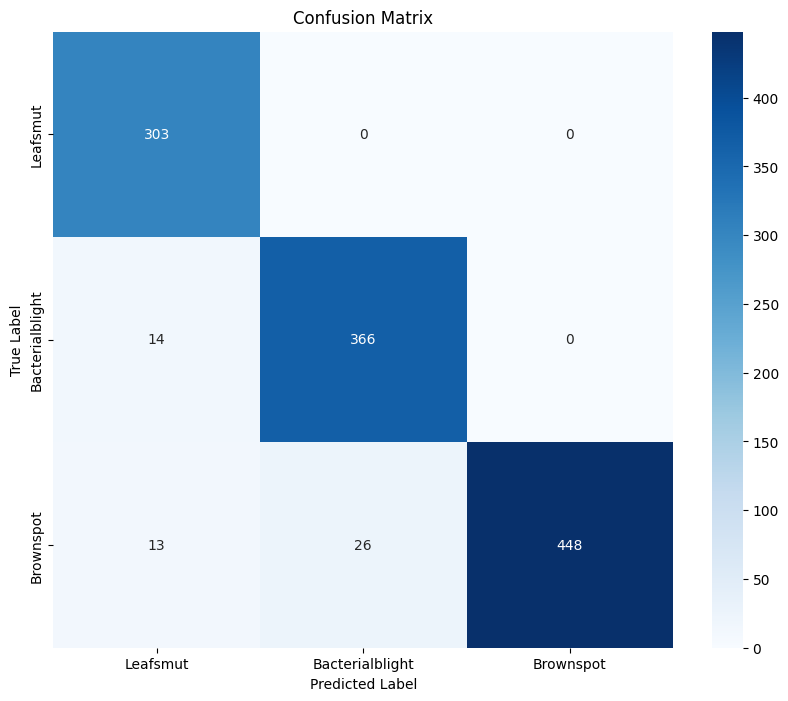

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix and classification report for validation
def evaluate_model(model, loader, label_mapping, device):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)

    # Classification report
    class_names = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]
    report = classification_report(y_true, y_pred, target_names=class_names)
    print('\nClassification Report:\n', report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_model(model, val_loader, full_dataset.label_mapping, device)

Total Images: 3898
Total Training Images: 2728
Total Validation Images: 1170


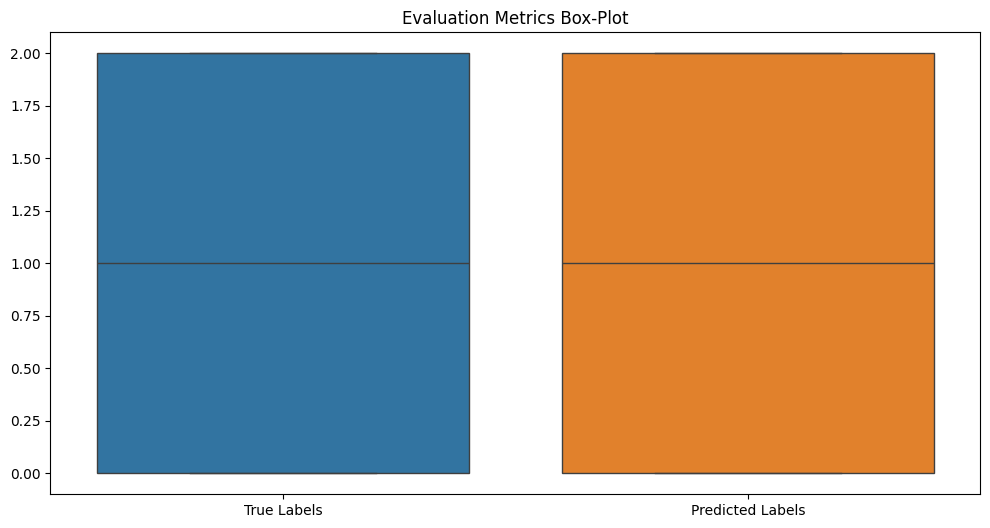

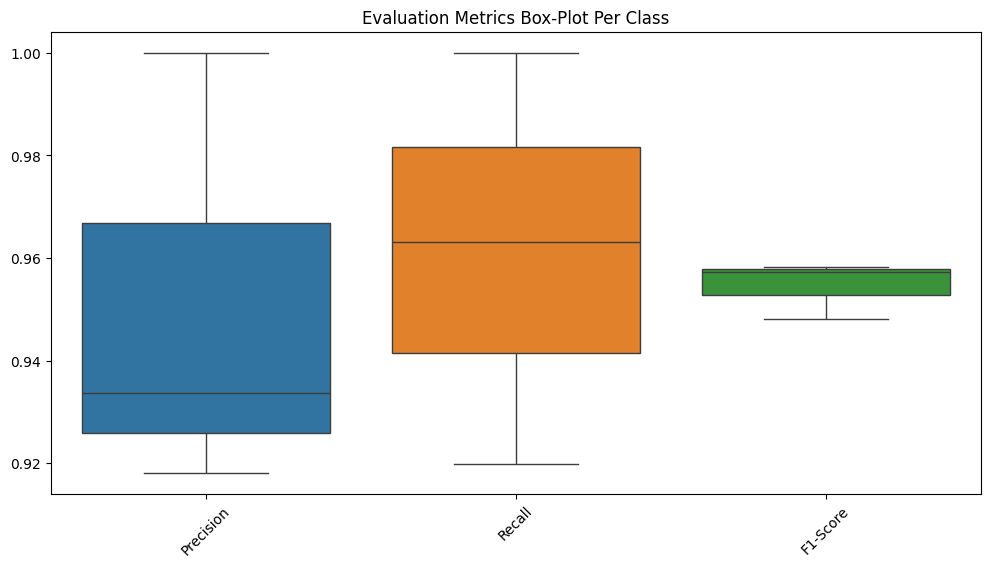

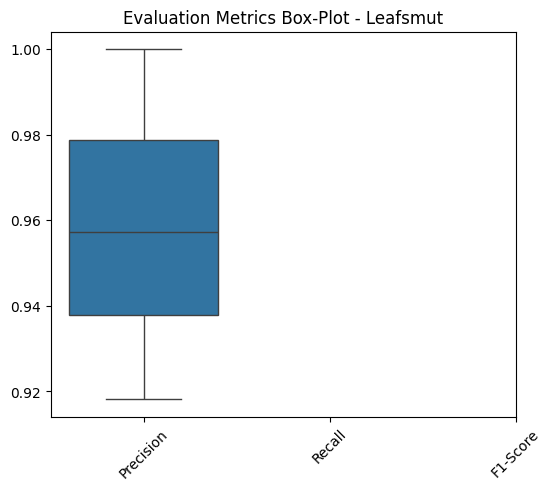

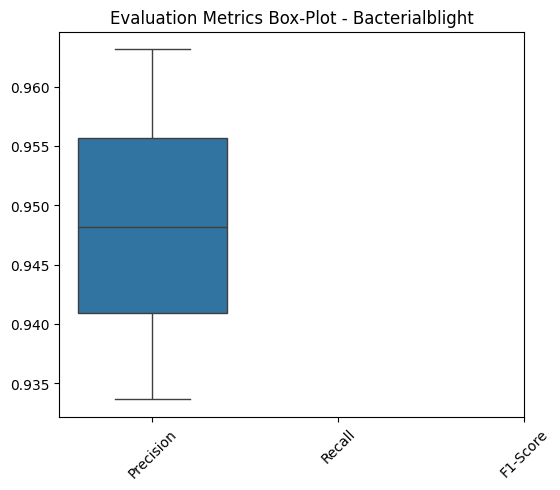

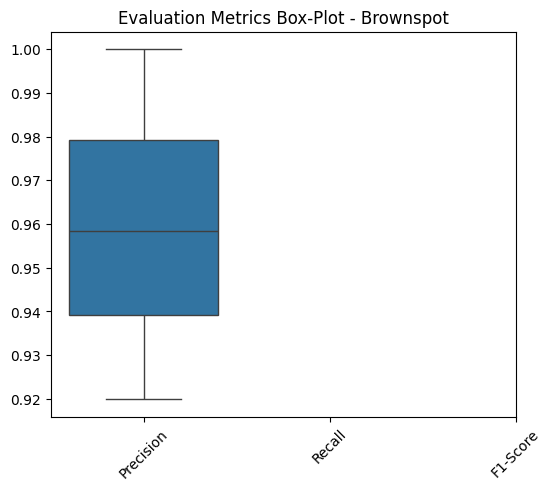

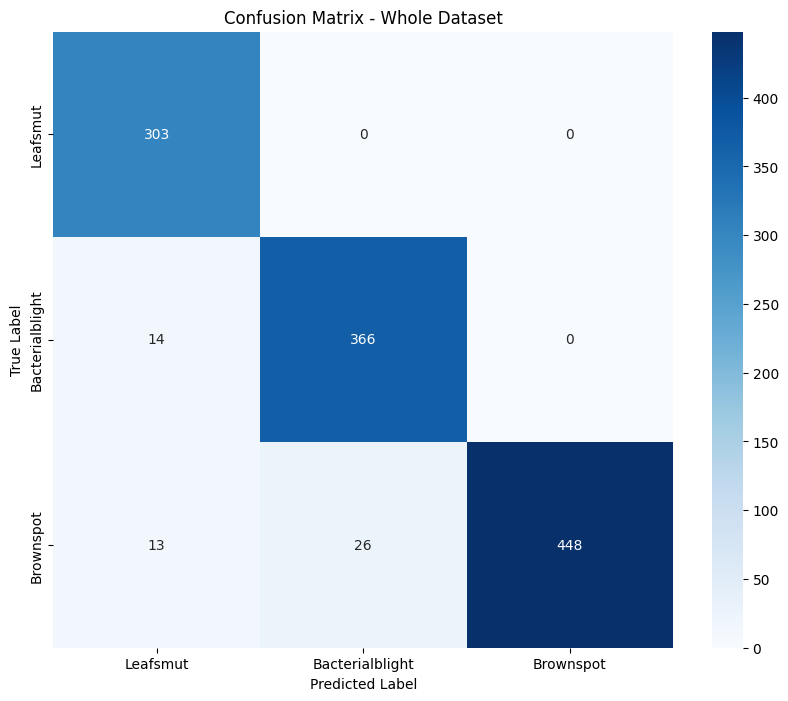

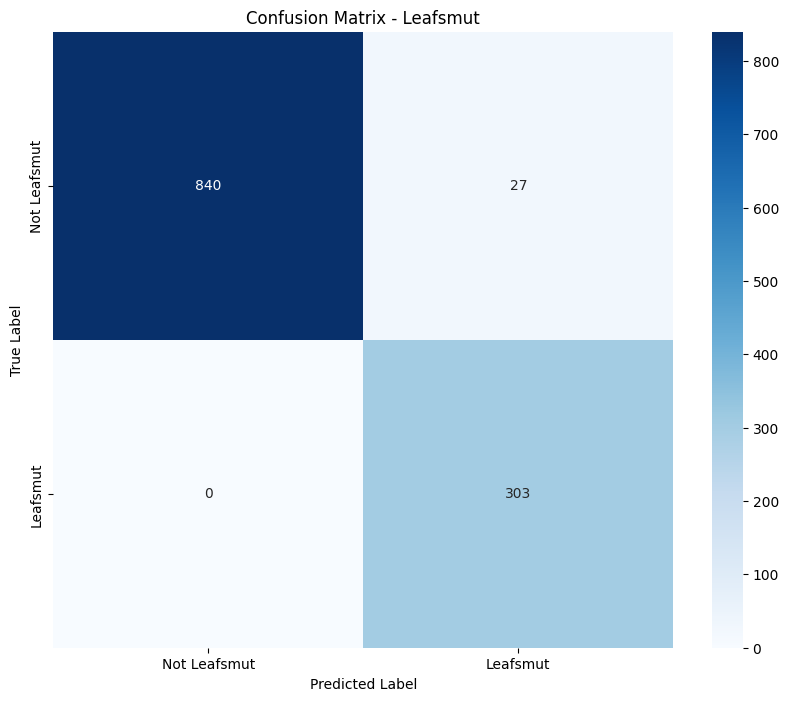

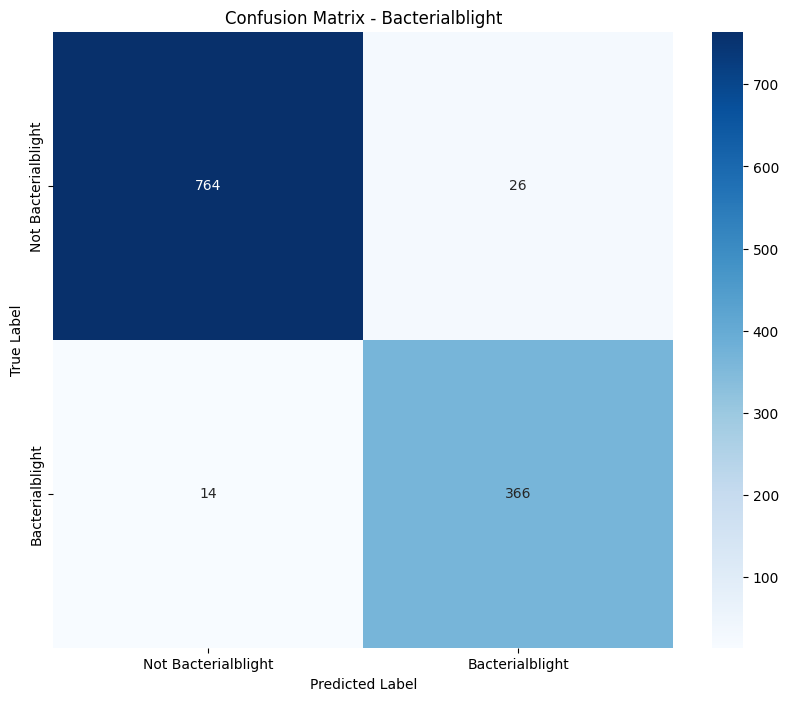

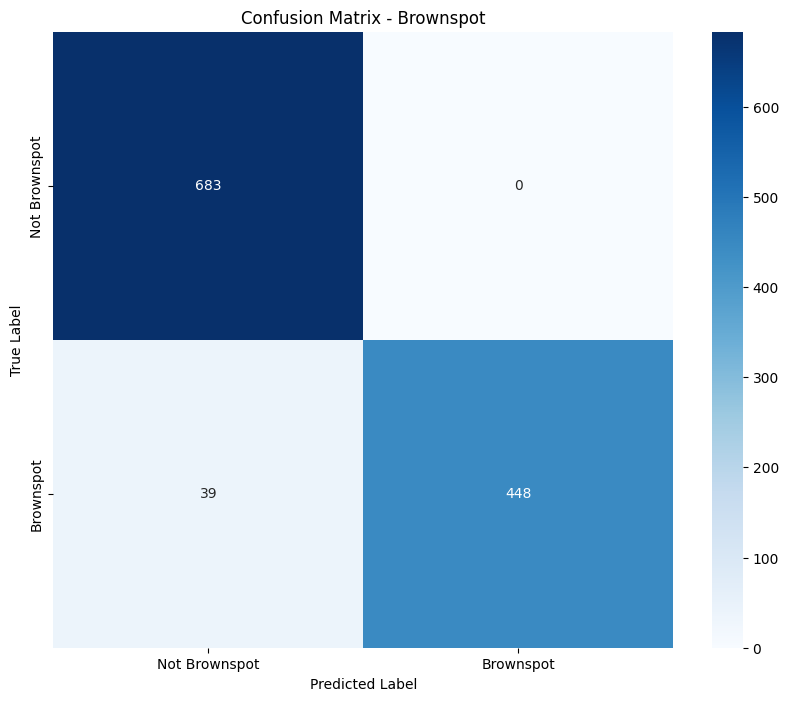

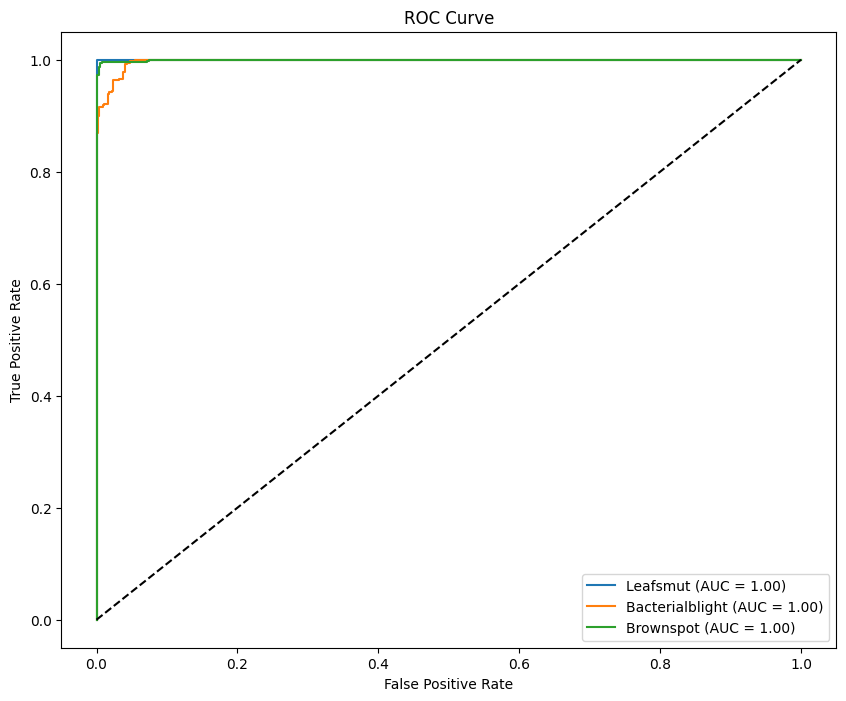

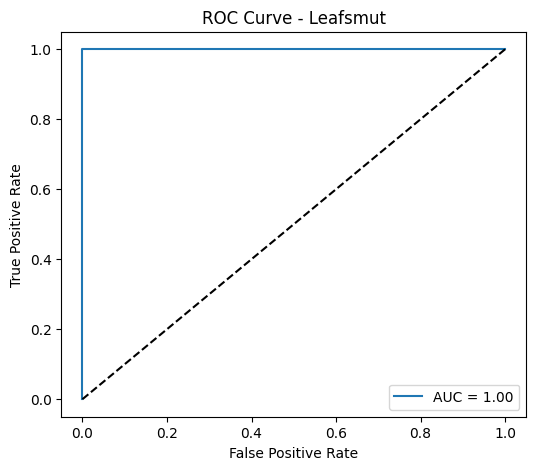

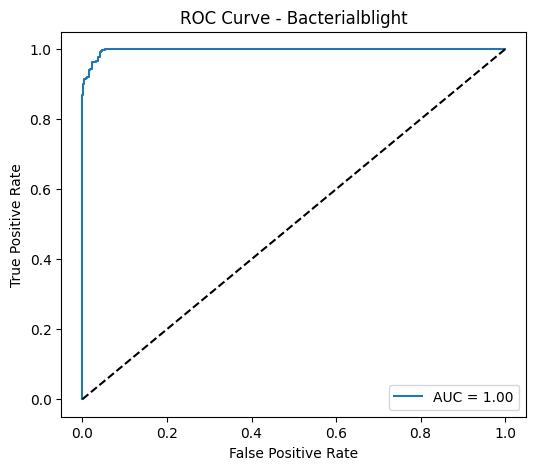

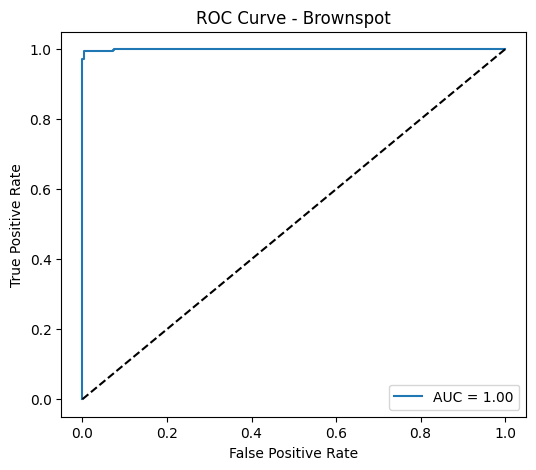

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import numpy as np
import torch

def plot_evaluation_matrix_boxplot(results, metric_names):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=results)
    plt.xticks(ticks=range(len(metric_names)), labels=metric_names)
    plt.title("Evaluation Metrics Box-Plot")
    plt.show()

def plot_evaluation_matrix_boxplot_per_class(y_true, y_pred, class_names):
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    metrics = [precision, recall, f1_score]
    metric_names = ["Precision", "Recall", "F1-Score"]

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=metrics)
    plt.xticks(ticks=range(len(metric_names)), labels=metric_names, rotation=45)
    plt.title("Evaluation Metrics Box-Plot Per Class")
    plt.show()

def plot_evaluation_matrix_boxplot_each_class(y_true, y_pred, class_names):
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    metric_names = ["Precision", "Recall", "F1-Score"]

    for i, class_name in enumerate(class_names):
        metrics = [precision[i], recall[i], f1_score[i]]
        plt.figure(figsize=(6, 5))
        sns.boxplot(data=metrics)
        plt.xticks(ticks=range(len(metric_names)), labels=metric_names, rotation=45)
        plt.title(f"Evaluation Metrics Box-Plot - {class_name}")
        plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_confusion_matrix_per_class(y_true, y_pred, class_names):
    for i, class_name in enumerate(class_names):
        binary_true = [1 if y == i else 0 for y in y_true]
        binary_pred = [1 if y == i else 0 for y in y_pred]
        plot_confusion_matrix(binary_true, binary_pred, ["Not " + class_name, class_name], title=f"Confusion Matrix - {class_name}")

def plot_confusion_matrix_per_batch(y_true_batches, y_pred_batches, class_names):
    for i, (y_true, y_pred) in enumerate(zip(y_true_batches, y_pred_batches)):
        plot_confusion_matrix(y_true, y_pred, class_names, title=f"Confusion Matrix - Batch {i+1}")

def plot_roc_curve(y_true, y_scores, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_roc_curve_per_class(y_true, y_scores, class_names):
    for i in range(len(class_names)):
        plt.figure(figsize=(6, 5))
        fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_names[i]}')
        plt.legend()
        plt.show()

def evaluate_model(model, loader, label_mapping, device):
    y_true, y_pred, y_scores = [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    class_names = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]
    plot_evaluation_matrix_boxplot([y_true, y_pred], ["True Labels", "Predicted Labels"])
    plot_evaluation_matrix_boxplot_per_class(y_true, y_pred, class_names)
    plot_evaluation_matrix_boxplot_each_class(y_true, y_pred, class_names)
    plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix - Whole Dataset")
    plot_confusion_matrix_per_class(y_true, y_pred, class_names)
    plot_roc_curve(np.array(y_true), np.array(y_scores), class_names)
    plot_roc_curve_per_class(np.array(y_true), np.array(y_scores), class_names)

dataset_statistics(train_loader, val_loader)
evaluate_model(model, val_loader, full_dataset.label_mapping, device)
